In [172]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

In [180]:
# Define the folders containing training result CSVs
folders = [
    "no_dense_layer", "dense_32", "dense_64", "dense_64_32"
]
# folders = [
#     "64_128_64_LSTM", "128_64_LSTM"
# ]
# folders = [
#     "no_dense_layer", "dense_32", "dense_64", "dense_64_32", "64_128_64_LSTM", "128_64_LSTM"
# ]
file_name = "training_results.csv"
base_output_folder = "output"
base_statistic_output = "statistic_output"
statistic_file_base = "dense_LSTM"


In [181]:
# Dictionary to store data for each model
model_data = {}

# Load data from each folder
for folder in folders:
    file_path = os.path.join(base_output_folder, folder, file_name)
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path, delimiter=",", header=0)  
            model_data[folder] = df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")


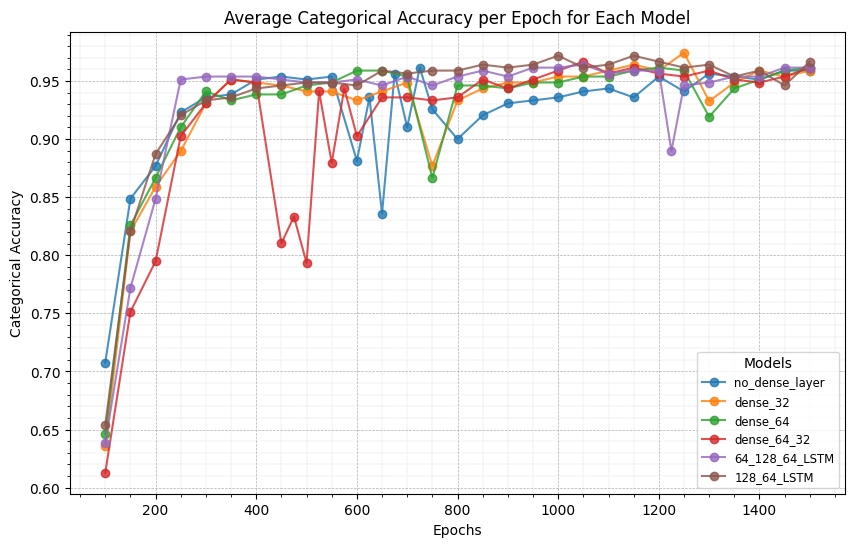

In [167]:
# Plot the average accuracy per epoch for each model without best-fit curves

plt.figure(figsize=(10, 6))

for folder, df in model_data.items():
    if "Epochs" in df.columns and "Categorical Accuracy" in df.columns:
        # Group by 'Epochs' to compute the average accuracy per epoch
        grouped = df.groupby("Epochs")["Categorical Accuracy"].mean().reset_index()
        epochs = grouped["Epochs"].values
        accuracies = grouped["Categorical Accuracy"].values
        
        # Plot the average accuracy as a line plot
        plt.plot(epochs, accuracies, label=f"{folder}", alpha=0.8, linestyle='-', marker='o')

plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.title("Average Categorical Accuracy per Epoch for Each Model")
plt.legend(title="Models", fontsize='small', loc="best")
plt.grid(True)

# Enable minor ticks on both axes
plt.minorticks_on()
plt.grid(which="both", linestyle="--", linewidth=0.5)  # Show both major and minor grid lines
plt.grid(which="minor", linestyle=":", linewidth=0.3)  # Make minor grid lines more subtle

# Save plot path
statistic_file = "Accuracy_" + statistic_file_base
output_path = os.path.join(base_statistic_output, statistic_file + ".png")

# Save the figure
plt.savefig(output_path, dpi=300, bbox_inches="tight")

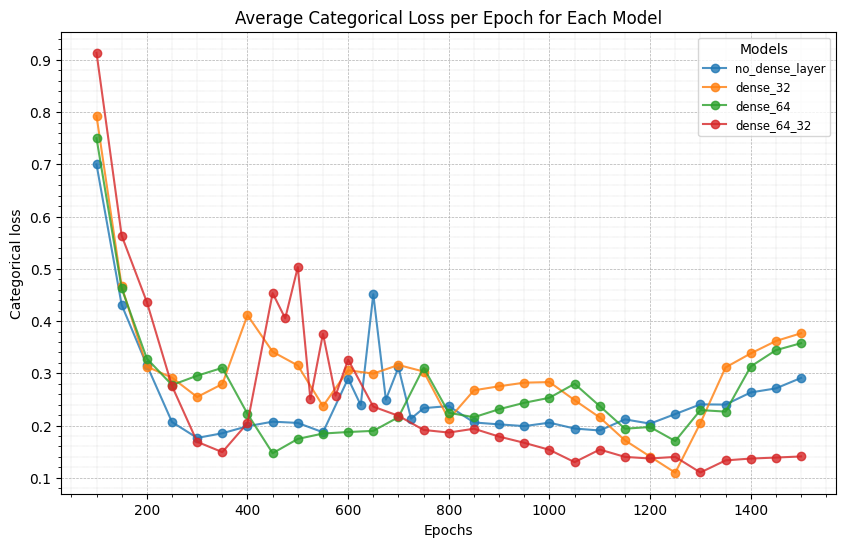

In [185]:
# Plot the average accuracy per epoch for each model without best-fit curves

plt.figure(figsize=(10, 6))

for folder, df in model_data.items():
    if "Epochs" in df.columns and "Loss" in df.columns:
        # Group by 'Epochs' to compute the average accuracy per epoch
        grouped = df.groupby("Epochs")["Loss"].mean().reset_index()
        epochs = grouped["Epochs"].values
        accuracies = grouped["Loss"].values
        
        # Plot the average accuracy as a line plot
        plt.plot(epochs, accuracies, label=f"{folder}", alpha=0.8, linestyle='-', marker='o')

plt.xlabel("Epochs")
plt.ylabel("Categorical loss")
plt.title("Average Categorical Loss per Epoch for Each Model")
plt.legend(title="Models", fontsize='small', loc="best")
plt.grid(True)

# Enable minor ticks on both axes
plt.minorticks_on()
plt.grid(which="both", linestyle="--", linewidth=0.5)  # Show both major and minor grid lines
plt.grid(which="minor", linestyle=":", linewidth=0.3)  # Make minor grid lines more subtle

# Save plot path
statistic_file = "loss_" + statistic_file_base
output_path = os.path.join(base_statistic_output, statistic_file + ".png")

# Save the figure
plt.savefig(output_path, dpi=300, bbox_inches="tight")

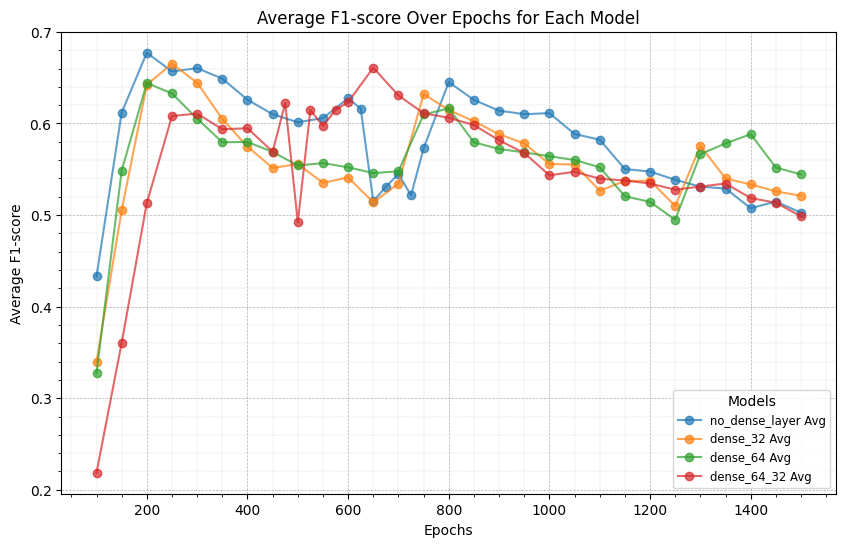

In [183]:
# Dictionary to store epoch-wise F1-score data for averaging per model
f1_scores_per_epoch_per_model = {}

# Process each model to compute average F1-score per epoch
for folder in folders:
    file_path = os.path.join(base_output_folder, folder, file_name)

    if os.path.exists(file_path):
        try:
            # Load CSV
            df_model = pd.read_csv(file_path, delimiter=",")

            # Ensure required columns exist
            if "Epochs" in df_model.columns and "Precision (OOD)" in df_model.columns and "Recall (OOD)" in df_model.columns:
                # Compute F1-score
                precision = df_model["Precision (OOD)"].fillna(0)
                recall = df_model["Recall (OOD)"].fillna(0)
                f1_scores = (2 * precision * recall) / (precision + recall)
                f1_scores = f1_scores.fillna(0)  # Handle divide-by-zero cases

                # Store F1-scores for averaging per epoch
                for epoch, f1 in zip(df_model["Epochs"], f1_scores):
                    if folder not in f1_scores_per_epoch_per_model:
                        f1_scores_per_epoch_per_model[folder] = {}
                    if epoch not in f1_scores_per_epoch_per_model[folder]:
                        f1_scores_per_epoch_per_model[folder][epoch] = []
                    f1_scores_per_epoch_per_model[folder][epoch].append(f1)

        except Exception as e:
            print(f"Error processing {folder} for averaged F1-score calculation: {e}")

# Compute average F1-score per epoch per model
average_f1_per_model = {}

for folder, epoch_data in f1_scores_per_epoch_per_model.items():
    avg_f1_per_epoch = {epoch: sum(f1_values) / len(f1_values) for epoch, f1_values in epoch_data.items()}
    average_f1_per_model[folder] = avg_f1_per_epoch

# Plot the F1-score per model with average trend per epoch
plt.figure(figsize=(10, 6))

for folder, avg_f1_data in average_f1_per_model.items():
    sorted_epochs = sorted(avg_f1_data.keys())
    sorted_avg_f1 = [avg_f1_data[epoch] for epoch in sorted_epochs]
    plt.plot(sorted_epochs, sorted_avg_f1, label=f"{folder} Avg", linestyle="-", marker="o", alpha=0.7)

# Configure plot
plt.xlabel("Epochs")
plt.ylabel("Average F1-score")
plt.title("Average F1-score Over Epochs for Each Model")
plt.legend(title="Models", fontsize="small", loc="best")
plt.grid(True)

# Enable minor ticks on both axes
plt.minorticks_on()
plt.grid(which="both", linestyle="--", linewidth=0.5)  # Show both major and minor grid lines
plt.grid(which="minor", linestyle=":", linewidth=0.3)  # Make minor grid lines more subtle


# Save plot path
statistic_file = "F1_" + statistic_file_base
output_path = os.path.join(base_statistic_output, statistic_file + ".png")

# Save the figure
plt.savefig(output_path, dpi=300, bbox_inches="tight")


In [169]:
# Function to parse and clean confusion matrix strings
def clean_conf_matrix(matrix_str):
    try:
        # Remove newlines and extra spaces
        matrix_str = matrix_str.replace("\n", " ").replace("[", "").replace("]", "")
        
        # Extract numbers using regex
        numbers = list(map(int, re.findall(r'\d+', matrix_str)))
        
        # Determine matrix size (assuming it's square)
        size = int(len(numbers) ** 0.5)
        
        # Reshape into a square matrix
        conf_matrix = np.array(numbers).reshape(size, size)
        
        return conf_matrix
    except Exception as e:
        print(f"Error parsing confusion matrix: {e}")
        return None

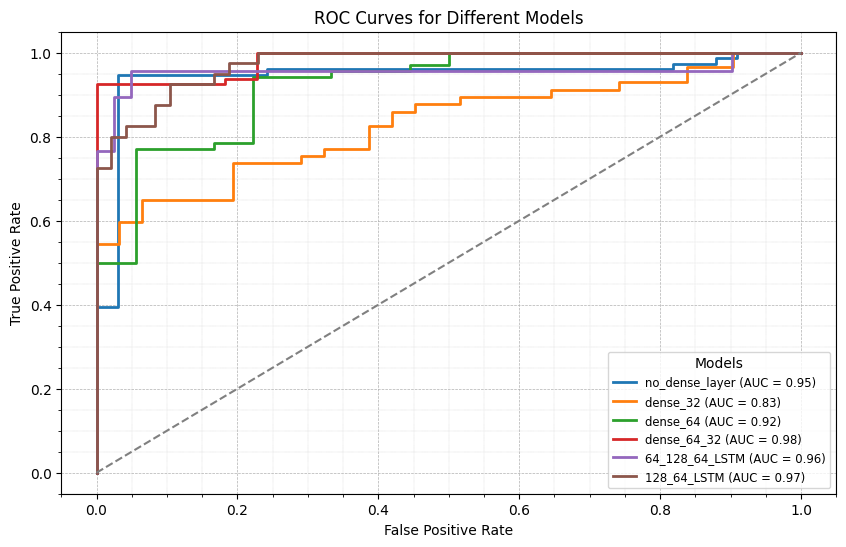

In [170]:
# Initialize figure for ROC curves
plt.figure(figsize=(10, 6))

# Dictionary to store AUC scores for each model
auc_scores = {}

# Process each model's CSV file
for folder in folders:
    file_path = os.path.join(base_output_folder, folder, file_name)
    
    if os.path.exists(file_path):
        try:
            # Load CSV
            df_model = pd.read_csv(file_path, delimiter=",")

            # Parse confusion matrices
            parsed_matrices = [clean_conf_matrix(cm) for cm in df_model["Conf Matrix (OOD)"]]

            # Extract y_true from parsed matrices
            y_true = []
            for conf_matrix in parsed_matrices:
                if conf_matrix is not None:
                    true_positive = np.trace(conf_matrix)  # Sum of diagonal elements
                    total_samples = np.sum(conf_matrix)  # Total instances in confusion matrix
                    y_true.append(1 if true_positive / total_samples > 0.5 else 0)
                else:
                    y_true.append(0)  # Default to 0 if parsing failed

            # Convert y_true to numpy array
            y_true = np.array(y_true)

            # Extract y_score from "Precision (OOD)" column
            y_score = df_model["Precision (OOD)"].to_numpy()

            # Compute ROC curve and AUC score
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)

            # Store AUC score for reference
            auc_scores[folder] = roc_auc

            # Plot the ROC curve for this model
            plt.plot(fpr, tpr, lw=2, label=f"{folder} (AUC = {roc_auc:.2f})")

        except Exception as e:
            print(f"Error processing {folder}: {e}")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Configure plot settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend(title="Models", fontsize="small", loc="best")
plt.grid(True)

# Enable minor ticks on both axes
plt.minorticks_on()
plt.grid(which="both", linestyle="--", linewidth=0.5)  # Show both major and minor grid lines
plt.grid(which="minor", linestyle=":", linewidth=0.3)  # Make minor grid lines more subtle

# Save plot path
statistic_file = "ROC_" + statistic_file_base
output_path = os.path.join(base_statistic_output, statistic_file + ".png")

# Save the figure
plt.savefig(output_path, dpi=300, bbox_inches="tight")
